# Experiment A.ii: Cross-worm Predictions with SHRED

Data obtained from Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

**Experiment A.ii: Extrapolating between worms**
- first three worms = training, 4th = validation, 5th = test
- randomly pick 3 neurons from group with high variance


In [1]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge


In [2]:
#Importing packages
HOME_DIR = "/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/neuralSHRED"

SHRED_DIR = os.path.join(HOME_DIR, "sindy-shred-main")
import sys 
sys.path.append(SHRED_DIR)

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"



/Users/amyrude/Downloads/Kutz_Research/SHRED_neuro/shredneuro/lib/python3.13/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


# Loading the Data
- 5 worms
- 18 mins at roughly 2.85 samples per second --> ~3000 samples per trial
- 107 - 131 neurons

In [3]:
# Loading the Dataset
os.chdir("../")

data_path = os.path.join(HOME_DIR, 'worms/data/WT_NoStim.mat')
data = loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'WT_NoStim', 'WT_Stim'])


In [4]:
# Working with the no stim condition -- WORM ONE
neuron = 0
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
print(neuron_data.shape)
time = no_stim[0][neuron][4]
dt = time[1][0] - time[0][0]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = no_stim[0][neuron][6][0][0]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')



neuron_one = neuron_data_cor[:1000,:]
time_one = time[:1000].flatten()
neuron_name_one = np.array(neuron_name)


(3137, 109)
number timepoints(m) 3137 number neurons(n): 109
dt 0.34427797258527254
sr 2.9046296296296297 Hz


In [5]:
# Working with the no stim condition -- WORM TWO
neuron = 1
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]
dt = time[1][0] - time[0][0]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])
sr = no_stim[0][neuron][6][0][0]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')


neuron_two = neuron_data_cor[:1000,:]
time_two = time[:1000].flatten() + np.ones(1000)*time_one[-1]
neuron_name_two = np.array(neuron_name)



number timepoints(m) 3134 number neurons(n): 135
dt 0.3446075303126994
sr 2.901851851851852 Hz


In [6]:
# Working with the no stim condition -- WORM THREE
neuron = 2
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]
dt = (dt+ time[1][0] - time[0][0])/2

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')



neuron_three = neuron_data_cor[:1000,:]
time_three = time[:1000].flatten()+ np.ones(1000)*time_two[-1]
neuron_name_three = np.array(neuron_name)




number timepoints(m) 3059 number neurons(n): 131
dt 0.34883204237112575
sr 2.8671296296296296 Hz


In [7]:
# Working with the no stim condition -- WORM FOUR
neuron = 3
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]
dt = (dt+ time[1][0] - time[0][0])/2

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')



neuron_four = neuron_data_cor[:1000,:]
time_four = time[:1000].flatten() + np.ones(1000)*time_three[-1]
neuron_name_four = np.array(neuron_name)



number timepoints(m) 3311 number neurons(n): 125
dt 0.33750874241781903
sr 2.966435185185185 Hz


In [8]:
# Working with the no stim condition -- WORM FIVE
neuron = 4
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]
dt = (dt+ time[1][0] - time[0][0])/2

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = (sr + no_stim[0][neuron][6][0][0])/2
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('dt', dt)
print('sr', sr, 'Hz')



neuron_five = neuron_data_cor[:1000,:]
time_five = time[:1000].flatten() + np.ones(1000)*time_four[-1]
neuron_name_five = np.array(neuron_name)


number timepoints(m) 3021 number neurons(n): 129
dt 0.3475031298980853
sr 2.881828703703704 Hz


In [9]:
#### Finding the neurons recorded from across all five worms 

common_values = np.intersect1d(neuron_name_one, neuron_name_two)
common_values = np.intersect1d(common_values, neuron_name_three)
common_values = np.intersect1d(common_values, neuron_name_four)
common_values = np.intersect1d(common_values, neuron_name_five)
print('common neurons', common_values)

#neuron one
indices = [np.where(neuron_name_one == q)[0] for q in common_values]
neuron_1 = np.squeeze(neuron_one[:,indices])

#neuron two
indices = [np.where(neuron_name_two == q)[0] for q in common_values]
neuron_2 = np.squeeze(neuron_two[:,indices])

#neuron three
indices = [np.where(neuron_name_three == q)[0] for q in common_values]
neuron_3 = np.squeeze(neuron_three[:,indices])

#neuron four
indices = [np.where(neuron_name_four == q)[0] for q in common_values]
neuron_4 = np.squeeze(neuron_four[:,indices])

#neuron five
indices = [np.where(neuron_name_five == q)[0] for q in common_values]
neuron_5 = np.squeeze(neuron_five[:,indices])



common neurons ['1' '10' '103' '105' '11' '12' '14' '18' '2' '20' '28' '3' '4' '47' '5'
 '50' '6' '7' '8' '86' '9' '92' '94' '99' 'AIBL' 'AIBR' 'ALA' 'ASKR'
 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVEL' 'AVER' 'RIBL' 'RID' 'RIML' 'RIMR'
 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB02']


(5000, 45)
45 5000


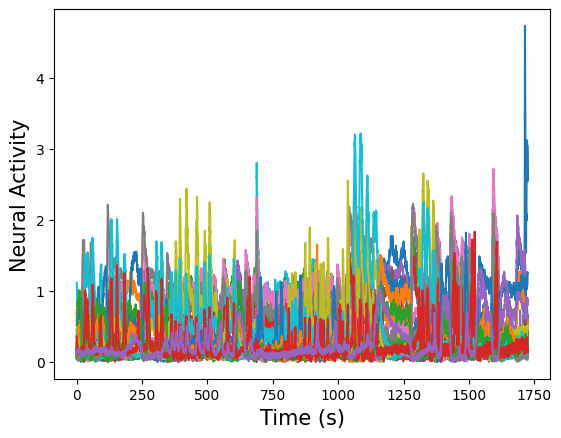

In [10]:
load_X = np.vstack((neuron_1, neuron_2, neuron_3, neuron_4, neuron_5))
time = np.hstack((time_one, time_two, time_three, time_four, time_five))
print(load_X.shape)

n_s = load_X.shape[1]
n_t = load_X.shape[0]
print(n_s, n_t)
plt.plot(time, load_X)
plt.xlabel('Time (s)', fontsize = 15)
plt.ylabel('Neural Activity', fontsize = 15)
plt.show()

Preparing the data 

**Select 3 randomly from high variance**

In [11]:
lags = 100
test_val_size = 2000 
train_indices = np.arange(0, n_t - lags - test_val_size)
mask = np.ones(n_t - lags)
mask[train_indices] = 0
valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
valid_indices = valid_test_indices[lags:1000]
test_indices = valid_test_indices[1000+lags:2000]

# print('valid', valid_indices)
# print('test',test_indices)

<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
/var/folders/vw/0t6vz1wn6rn5mgpcy6w188x00000gn/T/ipykernel_6758/1985204113.py:10: SyntaxWarning: invalid escape sequence '\s'
  plt.scatter(neuron_index, var, color = 'black', label = '$\sigma$')
/var/folders/vw/0t6vz1wn6rn5mgpcy6w188x00000gn/T/ipykernel_6758/1985204113.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma$', fontsize = 16)


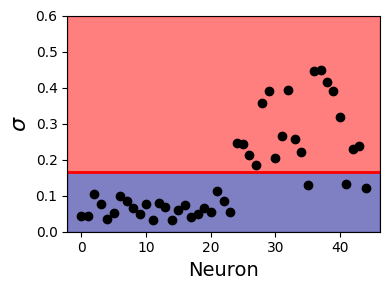

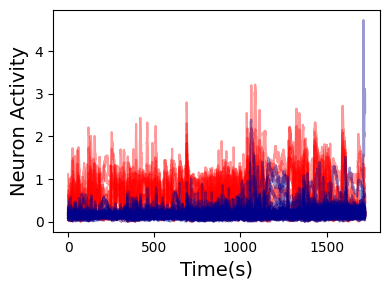

In [12]:
# Splitting into high and low variance groups
var = np.std(load_X[train_indices], axis = 0)
var_ave = np.mean(var)
neuron_index = np.arange(var.shape[0])

#plotting the distribution of std 
plt.figure(figsize = (4,3))
plt.axhspan(0, var_ave, color='darkblue', alpha=0.5)
plt.axhspan(var_ave,0.6 ,color='red', alpha=0.5)
plt.scatter(neuron_index, var, color = 'black', label = '$\sigma$')
plt.axhline(var_ave, color = 'red', linewidth = 2)
plt.xlabel('Neuron', fontsize = 14)
plt.ylabel('$\sigma$', fontsize = 16)
plt.ylim((0,0.6))
plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/std_scatter.png'), transparent=True, dpi=500)
plt.show()


# Finding indices for high variance cases
high_ind = np.where(var > var_ave)[0]
low_ind = np.where(var < var_ave)[0]
plt.figure(figsize = (4,3))
plt.plot(time, load_X[:,high_ind], color = 'red', alpha = 0.4)
plt.plot(time, load_X[:,low_ind], color = 'darkblue', alpha = 0.4)
plt.xlabel('Time(s)', fontsize = 14)
plt.ylabel('Neuron Activity', fontsize = 14)
plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs//var_traces.svg'), transparent=True, dpi=500)
plt.show()



Text(0, 0.5, 'Neurons')

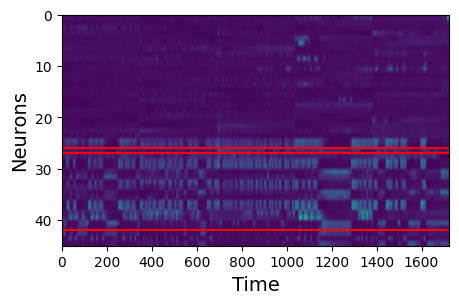

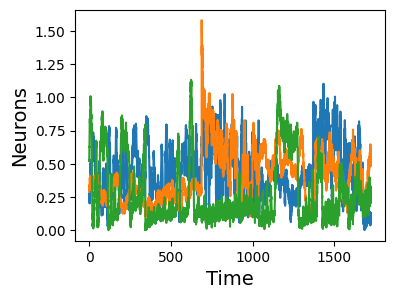

In [13]:
num_neurons = 3 

# Randomly select the neurons to train the SHRED model on
indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
neuron_locations = high_ind[indices]

#Plotting the Carpet plot
plt.figure(figsize = (5,3))
plt.imshow(load_X.T, aspect = 'auto', extent=[time[0], time[-1], n_s,0])

plt.xlabel('Time', fontsize = 14)
plt.ylabel('Neurons',fontsize = 14)

for i in range(neuron_locations.shape[0]):
  plt.axhline(neuron_locations[i], color = 'red')


plt.figure(figsize = (4,3))
plt.plot(time, load_X[:,neuron_locations])
plt.xlabel('Time', fontsize = 14)
plt.ylabel('Neurons', fontsize = 14)

In [24]:
latent_dim = 32
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
import sindy_shred



## high variance
for k in range(1,2): #Dictates number of trials to run
    # Randomly select the neurons to train the SHRED model on
    indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
    neuron_locations = high_ind[indices]
    file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/neuron_loc_{k}.npy')
    np.save(file_path, neuron_locations)
    sc = MinMaxScaler()
    sc = sc.fit(load_X[train_indices])
    transformed_X = sc.transform(load_X)

    ### Generate input sequences to a SHRED model
    all_data_in = np.zeros((n_t - lags, lags, num_neurons))
    for i in range(len(all_data_in)):
        all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

    ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
    valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
    test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

    ### -1 to have output be at the same time as final sensor measurements
    train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
    valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
    test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

    train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
    valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
    test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

    shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                    library_dim=library_dim, poly_order=poly_order,
                                    include_sine=include_sine, dt=dt, sindy = False, layer_norm=False).to(device)

    validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                        lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=0.0,
                                        optimizer="AdamW", thres_epoch=100)
    
    test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
    test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
    mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
    print('mse test', mse_test)
    train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
    train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
    mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
    print('mse train', mse_train)

    file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/train_recon_{k}.npy')
    np.save(file_path, train_recons)

    file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/test_recon_{k}.npy')
    np.save(file_path, test_recons)


    file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/train_gt_{k}.npy')
    np.save(file_path, train_ground_truth)

    file_path = os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/test_gt_{k}.npy')
    np.save(file_path, test_ground_truth)

1 : tensor(0.0393, grad_fn=<AddBackward0>)
2 : tensor(0.0322, grad_fn=<AddBackward0>)
3 : tensor(0.0300, grad_fn=<AddBackward0>)
4 : tensor(0.0296, grad_fn=<AddBackward0>)
5 : tensor(0.0290, grad_fn=<AddBackward0>)
6 : tensor(0.0290, grad_fn=<AddBackward0>)
7 : tensor(0.0301, grad_fn=<AddBackward0>)
8 : tensor(0.0288, grad_fn=<AddBackward0>)
9 : tensor(0.0273, grad_fn=<AddBackward0>)
10 : tensor(0.0269, grad_fn=<AddBackward0>)
11 : tensor(0.0269, grad_fn=<AddBackward0>)
12 : tensor(0.0267, grad_fn=<AddBackward0>)
13 : tensor(0.0283, grad_fn=<AddBackward0>)
14 : tensor(0.0279, grad_fn=<AddBackward0>)
15 : tensor(0.0259, grad_fn=<AddBackward0>)
16 : tensor(0.0258, grad_fn=<AddBackward0>)
17 : tensor(0.0257, grad_fn=<AddBackward0>)
18 : tensor(0.0261, grad_fn=<AddBackward0>)
19 : tensor(0.0262, grad_fn=<AddBackward0>)
20 : tensor(0.0260, grad_fn=<AddBackward0>)
21 : tensor(0.0254, grad_fn=<AddBackward0>)
22 : tensor(0.0249, grad_fn=<AddBackward0>)
23 : tensor(0.0249, grad_fn=<AddBackward0

## Plotting the Data

<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:51: SyntaxWarning: invalid escape sequence '\D'
/var/folders/vw/0t6vz1wn6rn5mgpcy6w188x00000gn/T/ipykernel_6758/1490996198.py:30: SyntaxWarning: invalid escape sequence '\D'
  cbar.set_label("$\Delta$F/$F_0$", fontsize = 12)
/var/folders/vw/0t6vz1wn6rn5mgpcy6w188x00000gn/T/ipykernel_6758/1490996198.py:51: SyntaxWarning: invalid escape sequence '\D'
  cbar.set_label("$\Delta$F/$F_0$", fontsize = 12)


(900, 45)
(45, 3800)


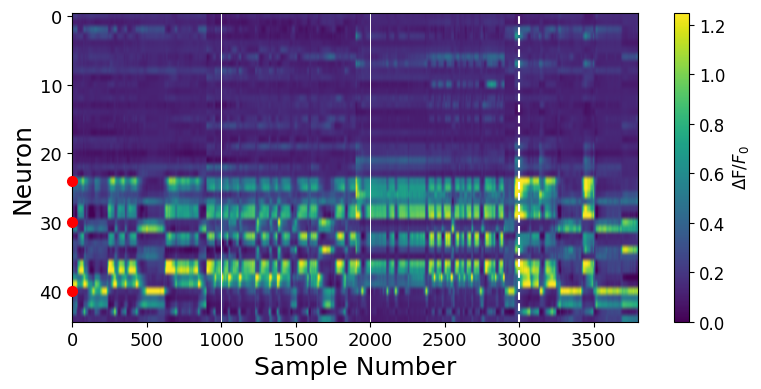

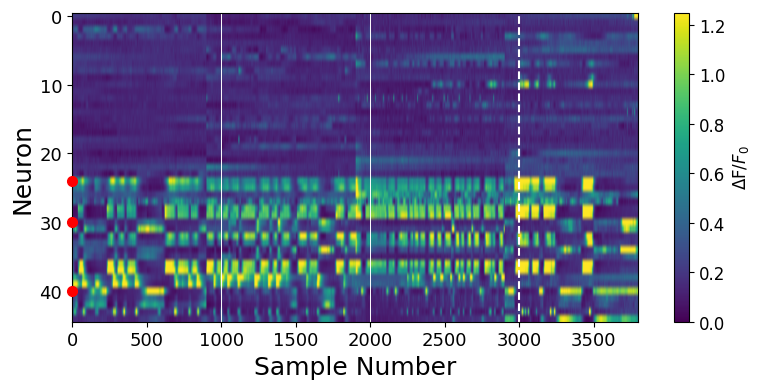

(42, 900)
(2900, 45)
[np.float32(0.22258274), np.float32(0.58043724)]


In [25]:
trial = 1

data = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/train_recon_{trial}.npy'))
train_recons = data
data = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/test_recon_{trial}.npy'))
test_recons = data

data = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/train_gt_{trial}.npy'))
train_ground_truth = data
data = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/test_gt_{trial}.npy'))
test_ground_truth= data

neuron_loc = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/neuron_loc_{trial}.npy'))

data_recons = np.hstack((train_recons.T, test_recons.T))
print(test_recons.shape)
print(data_recons.shape)
fig, ax = plt.subplots(figsize = (8,4))
plt.imshow(data_recons, aspect = 'auto', vmin= 0, vmax=1.25)
plt.axvline(3000, color = 'white', linestyle = '--')
plt.axvline(1000, color = 'white', linewidth = 0.7)
plt.axvline(2000, color = 'white', linewidth = 0.7)
for loc in neuron_loc:
    ax.plot(0.1, loc, 'ro', markersize=7, clip_on=False, zorder=10)
plt.tick_params(axis='both', which='major', labelsize=13)

plt.xlabel('Sample Number', fontsize = 18)
plt.ylabel('Neuron', fontsize = 18)
cbar = plt.colorbar()
cbar.set_label("$\Delta$F/$F_0$", fontsize = 12)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/expAii_recons.png'), transparent=True, dpi=500)

plt.show()


data_gt = np.hstack((train_ground_truth.T, test_ground_truth.T))
fig, ax = plt.subplots(figsize = (8,4))
plt.imshow(data_gt, aspect = 'auto', vmin=0, vmax=1.25)
plt.axvline(3000, color = 'white', linestyle = '--')
plt.axvline(1000, color = 'white', linewidth = 0.7)
plt.axvline(2000, color = 'white', linewidth = 0.7)
plt.xlabel('Sample Number', fontsize = 18)
plt.ylabel('Neuron', fontsize = 18)
for loc in neuron_loc:
    ax.plot(0.1, loc, 'ro', markersize=7, clip_on=False, zorder=10)
plt.tick_params(axis='both', which='major', labelsize=13)

cbar = plt.colorbar()
cbar.set_label("$\Delta$F/$F_0$", fontsize = 12)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/expAii_gt.png'), transparent=True, dpi=500)
plt.show()

mask = np.ones(train_recons.shape[1], dtype=bool)
mask[neuron_loc] = False
train_ex = train_recons.T[mask]
train_gt_ex = train_ground_truth.T[mask]

mask = np.ones(test_recons.shape[1], dtype=bool)
mask[neuron_loc] = False
test_ex = test_recons.T[mask]
test_gt_ex = test_ground_truth.T[mask]
print(test_ex.shape)
print(train_ground_truth.shape)
mse_train = np.linalg.norm(train_ex - train_gt_ex) / np.linalg.norm(train_gt_ex)
mse_test = np.linalg.norm(test_ex - test_gt_ex) / np.linalg.norm(test_gt_ex)
print([mse_train, mse_test])

test out shape (900, 45)
data out shape (3800, 45)


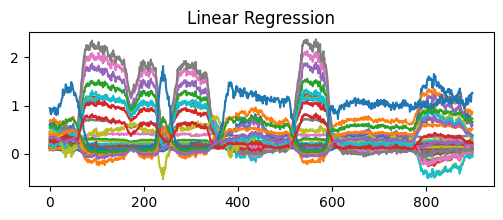

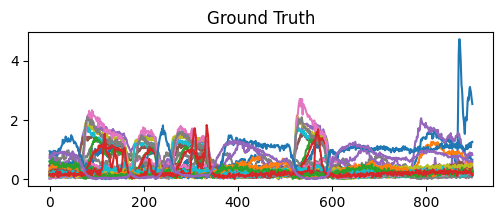

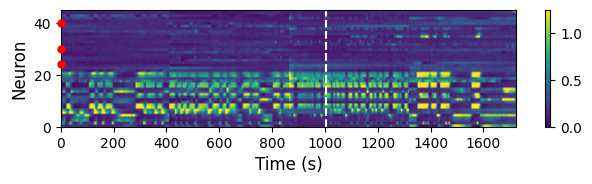

out shape (3800, 45)


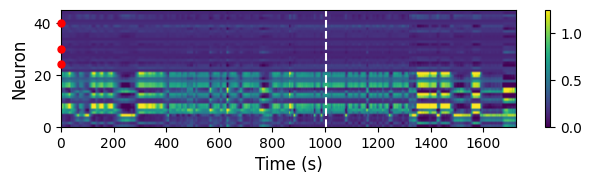

mse train, test [np.float32(0.40535414), np.float32(0.55849046)]
mse whole 0.45189717


In [31]:
##### Linear Regression

from sklearn.linear_model import LinearRegression

name = 1
neuron_loc = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/neuron_loc_{name}.npy'))
train_gt = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/train_gt_{name}.npy'))
test_gt = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/test_gt_{name}.npy'))
data_gt = np.vstack((train_gt, test_gt))
train_recon = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/train_recon_{name}.npy'))
test_recon = np.load(os.path.join(HOME_DIR, f'worms/data_output/exp_Aii/test_recon_{name}.npy'))
data_recon = np.vstack((train_recon, test_recon))
time = np.hstack((time_one, time_two, time_three, time_four, time_five))

train_in = train_gt[:, neuron_loc]
test_in = test_gt[:, neuron_loc]
data_in = data_gt[:, neuron_loc]
train_out = train_gt



model = LinearRegression()
model.fit(train_in, train_out)

test_out = model.predict(test_in)
print('test out shape',test_out.shape)
data_out = model.predict(data_in)
print('data out shape',data_out.shape)
plt.figure(figsize = (6,2))
plt.plot(test_out)
plt.title('Linear Regression')
plt.show()

plt.figure(figsize = (6,2))
plt.plot(test_gt)
plt.title('Ground Truth')
plt.show()

######### Plotting the reconstruction
fig, ax = plt.subplots(figsize = (6.5,2))
plt.imshow(data_gt.T, aspect = "auto", extent = [0, time[-1],0,data_gt.shape[1]], vmin = 0, vmax = 1.25)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Neuron', fontsize =12)
plt.axvline(time[train_gt.shape[0]], color = 'white', linestyle = '--')
# Add red dots for neuron locations on y-axis
for loc in neuron_loc:
    ax.plot(0.1, loc, 'ro', markersize=5, clip_on=False, zorder=10)

plt.colorbar()
plt.tight_layout()
# plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/{name}_recon.png'), transparent = True, dpi = 400)

plt.show()

print('out shape',data_out.shape)
fig, ax = plt.subplots(figsize = (6.5,2))
plt.imshow(data_out.T, aspect = "auto", extent = [0, time[-1],0,data_out.shape[1]], vmin = 0, vmax = 1.25)
plt.xlabel('Time (s)', fontsize = 12)
plt.ylabel('Neuron', fontsize = 12)
plt.colorbar()
plt.axvline(time[train_gt.shape[0]], color = 'white', linestyle = '--')
# Add red dots for neuron locations on y-axis
for loc in neuron_loc:
    ax.plot(0.1, loc, 'ro', markersize=5, clip_on=False, zorder=10)
plt.tight_layout()
# plt.savefig(os.path.join(HOME_DIR, f'worms/data_output/figs/{name}_linear.png'), transparent = True, dpi = 400)
plt.show()

n_train = train_out.shape[0]
mask = np.ones(train_out.shape[1], dtype=bool)
mask[neuron_loc] = False
train_ex = data_out[:n_train,:].T[mask]
train_gt_ex = train_gt.T[mask]
mask = np.ones(test_out.shape[1], dtype=bool)
mask[neuron_loc] = False
test_ex = test_out.T[mask]
test_gt_ex = test_gt.T[mask]
mse_train = np.linalg.norm(train_ex - train_gt_ex) / np.linalg.norm(train_gt_ex)
mse_test = np.linalg.norm(test_ex - test_gt_ex) / np.linalg.norm(test_gt_ex)
print('mse train, test', [mse_train, mse_test])


mask = np.ones(train_out.shape[1], dtype=bool)
mask[neuron_loc] = False
data_ex = data_out.T[mask]
data_gt_ex = data_gt.T[mask]
mse_whole = np.linalg.norm(data_ex - data_gt_ex) / np.linalg.norm(data_gt_ex)
print('mse whole', mse_whole)

In [32]:
print(data_in.shape)

(3800, 3)
